In [1]:
import cartopy.crs
from cartopy import feature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean.cm
import numpy
import xarray
import pandas
import pathlib
import yaml

##### file paths and names

In [2]:
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)

fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")

location_dir = pathlib.Path('/Users/rmueller/Data/MIDOSS/AIS')
location_file = location_dir / 'Oil_Transfer_Facilities.xlsx'
wa_oil_in = pathlib.Path('/Users/rmueller/Data/MIDOSS/marine_transport_data') / 'WA_destination.yaml'

In [3]:
vessel_types = [
    'tanker', 
    'atb', 
    'barge'
]
oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]
oil_colors = [
    'darkolivegreen',
    'olivedrab',
    'slategrey',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]
gallons_to_liters = 3.78541

### Load locations of marine transfer facilities

##### read in oil attribute data

In [4]:
with open(wa_oil_in) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

In [5]:
oil_attrs['Alon Asphalt Company (Paramount Petroleum)']['barge']['diesel']

{'fraction_of_total': 0.6440647319410542,
 'number_of_transfers': 28,
 'total_gallons': 14960400}

In [6]:
oil_attrs.keys()

dict_keys(['Alon Asphalt Company (Paramount Petroleum)', 'Andeavor Anacortes Refinery (formerly Tesoro)', 'BP Cherry Point Refinery', 'Kinder Morgan Liquids Terminal - Harbor Island', 'Maxum (Rainer Petroleum)', 'NAVSUP Manchester', 'Naval Air Station Whidbey Island (NASWI)', 'Nustar Energy Tacoma', 'Phillips 66 Ferndale Refinery', 'Phillips 66 Tacoma Terminal', 'REG Grays Harbor, LLC', 'SeaPort Sound Terminal', 'Shell Oil LP Seattle Distribution Terminal', 'Shell Puget Sound Refinery', 'TLP Management Services LLC (TMS)', 'Tesoro Pasco Terminal', 'Tesoro Port Angeles Terminal', 'Tesoro Vancouver Terminal', 'Tidewater Snake River Terminal', 'Tidewater Vancouver Terminal', 'U.S. Oil & Refining', 'names'])

##### read in locations for marine transfer facilities

In [7]:
wa_locs = pandas.read_excel(location_file, sheet_name='Washington', 
                   usecols="B,I,J")
bc_locs = pandas.read_excel(location_file, sheet_name='British Columbia', 
                   usecols="A,B,C")

##### find and correct entries that differ between DOE naming and Casey's name list (I plan to correct these names so we are self-consistent)

In [8]:
for location in wa_locs['FacilityName']:
    if location not in oil_attrs.keys():
        print(location)

Maxum Petroleum - Harbor Island Terminal
Marathon Anacortes Refinery (formerly Tesoro)
Nustar Energy Vancouver


In [9]:
# Maxum Petroleum - Harbor Island Terminal -> 'Maxum (Rainer Petroleum)'
# Marathon Anacortes Refinery (formerly Tesoro) -> 'Andeavor Anacortes Refinery (formerly Tesoro)'
# Nustar Energy Vancouver -> Not included

In [10]:
for location in wa_locs['FacilityName']:
    if location == 'Marathon Anacortes Refinery (formerly Tesoro)':
#         wa_locs[wa_locs['FacilityName']=='Marathon Anacortes Refinery (formerly Tesoro)'].FacilityName = (
#             'Andeavor Anacortes Refinery (formerly Tesoro)'
#         )
         wa_locs.loc[wa_locs['FacilityName']=='Marathon Anacortes Refinery (formerly Tesoro)','FacilityName'] = (
                    'Andeavor Anacortes Refinery (formerly Tesoro)'
                )
    elif location == 'Maxum Petroleum - Harbor Island Terminal':
        wa_locs.loc[wa_locs['FacilityName']=='Maxum Petroleum - Harbor Island Terminal','FacilityName'] = (
            'Maxum (Rainer Petroleum)'
        )
wa_locs.drop(index=17, inplace=True)
wa_locs.reset_index( drop=True, inplace=True )
wa_locs

,FacilityName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,48.86111,-122.758
1,Shell Puget Sound Refinery,48.50945,-122.577
2,Shell Oil LP Seattle Distribution Terminal,47.58870,-122.353
3,Maxum (Rainer Petroleum),47.58753,-122.353
4,Tidewater Snake River Terminal,46.22312,-119.014
5,Nustar Energy Tacoma,47.26091,-122.436
6,SeaPort Sound Terminal,47.27679,-122.389
7,Tesoro Vancouver Terminal,45.63551,-122.703
8,Phillips 66 Ferndale Refinery,48.82600,-122.720
9,Phillips 66 Tacoma Terminal,47.25816,-122.434


In [11]:
# remove locations outside of Salish Sea
non_salish_locs = wa_locs[wa_locs['DockLatNumber']<47].index
wa_locs.drop(index=non_salish_locs, inplace=True)
wa_locs.reset_index( drop=True, inplace=True )
wa_locs

,FacilityName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,48.86111,-122.758
1,Shell Puget Sound Refinery,48.50945,-122.577
2,Shell Oil LP Seattle Distribution Terminal,47.58870,-122.353
3,Maxum (Rainer Petroleum),47.58753,-122.353
4,Nustar Energy Tacoma,47.26091,-122.436
5,SeaPort Sound Terminal,47.27679,-122.389
6,Phillips 66 Ferndale Refinery,48.82600,-122.720
7,Phillips 66 Tacoma Terminal,47.25816,-122.434
8,Andeavor Anacortes Refinery (formerly Tesoro),48.50837,-122.569
9,Tesoro Port Angeles Terminal,48.13615,-123.462


### Add oil entries to dataframe

In [12]:
for oil in oil_types:
    wa_locs[oil] = numpy.zeros(len(wa_locs['FacilityName']))
    wa_locs[f'{oil}_scale'] = numpy.zeros(len(wa_locs['FacilityName']))

### loop through all facilities and get the total amount of fuel by fuel type

In [13]:
wa_locs['all'] = numpy.zeros(len(wa_locs['FacilityName']))

for index in range(len(wa_locs)):
    for oil in oil_types:
        for vessel in vessel_types:
            # add oil accross vessel types and convert to liters while we are at it
            wa_locs.loc[index, oil] += oil_attrs[wa_locs.FacilityName[index]][vessel][oil]['total_gallons']
        
        # add oil across oil types
        wa_locs.loc[index,'all'] += wa_locs.loc[index,oil]

# Now make a scale to use for marker size
for oil in oil_types:
    wa_locs[f'{oil}_scale'] = wa_locs[oil]/wa_locs[oil].sum()
    print(wa_locs[f'{oil}_scale'].sum())
    
wa_locs['all_scale'] = wa_locs['all']/wa_locs['all'].sum()

1.0
1.0
0.0
1.0
1.0
1.0
0.9999999999999999


In [14]:
wa_locs

,FacilityName,DockLatNumber,DockLongNumber,akns,akns_scale,bunker,bunker_scale,dilbit,dilbit_scale,jet,jet_scale,diesel,diesel_scale,gas,gas_scale,other,other_scale,all,all_scale
0,BP Cherry Point Refinery,48.86111,-122.758,1.652454e+09,0.429764,74351256.0,0.186133,0.0,NaN,34062630.0,0.354747,27749526.0,0.151674,73476690.0,0.221112,133726320.0,0.423276,1.995820e+09,0.385913
1,Shell Puget Sound Refinery,48.50945,-122.577,1.264963e+09,0.328987,281820.0,0.000706,0.0,NaN,0.0,0.000000,304500.0,0.001664,10293150.0,0.030975,43691750.0,0.138295,1.319534e+09,0.255146
2,Shell Oil LP Seattle Distribution Terminal,47.58870,-122.353,0.000000e+00,0.000000,0.0,0.000000,0.0,NaN,0.0,0.000000,0.0,0.000000,4242000.0,0.012765,0.0,0.000000,4.242000e+06,0.000820
3,Maxum (Rainer Petroleum),47.58753,-122.353,0.000000e+00,0.000000,0.0,0.000000,0.0,NaN,0.0,0.000000,28000.0,0.000153,0.0,0.000000,0.0,0.000000,2.800000e+04,0.000005
4,Nustar Energy Tacoma,47.26091,-122.436,0.000000e+00,0.000000,0.0,0.000000,0.0,NaN,0.0,0.000000,0.0,0.000000,3360000.0,0.010111,0.0,0.000000,3.360000e+06,0.000650
5,SeaPort Sound Terminal,47.27679,-122.389,0.000000e+00,0.000000,92118848.0,0.230613,0.0,NaN,0.0,0.000000,7392000.0,0.040403,64323000.0,0.193566,11314019.0,0.035812,1.751479e+08,0.033867
6,Phillips 66 Ferndale Refinery,48.82600,-122.720,5.674200e+08,0.147572,924000.0,0.002313,0.0,NaN,0.0,0.000000,344400.0,0.001882,1302000.0,0.003918,7518000.0,0.023796,5.775084e+08,0.111667
7,Phillips 66 Tacoma Terminal,47.25816,-122.434,0.000000e+00,0.000000,3423000.0,0.008569,0.0,NaN,0.0,0.000000,18879000.0,0.103189,71889800.0,0.216336,0.0,0.000000,9.419180e+07,0.018213
8,Andeavor Anacortes Refinery (formerly Tesoro),48.50837,-122.569,3.402405e+08,0.088488,8400000.0,0.021029,0.0,NaN,10752000.0,0.111977,52332800.0,0.286042,67956000.0,0.204498,91988400.0,0.291165,5.716697e+08,0.110538
9,Tesoro Port Angeles Terminal,48.13615,-123.462,0.000000e+00,0.000000,21151996.0,0.052953,0.0,NaN,0.0,0.000000,2778218.0,0.015185,0.0,0.000000,315000.0,0.000997,2.424521e+07,0.004688


### Sort facilities into latitude bins

In [24]:
lat_partition = [48, 48.15, 48.3, 48.7]

south  = wa_locs[wa_locs.DockLatNumber < lat_partition[0]]

portangeles = wa_locs[
    (wa_locs.DockLatNumber > lat_partition[0]) & 
    (wa_locs.DockLatNumber < lat_partition[1])
]

naswi = wa_locs[
    (wa_locs.DockLatNumber > lat_partition[1]) & 
    (wa_locs.DockLatNumber < lat_partition[2])
]

anacortes  = wa_locs[
    (wa_locs.DockLatNumber > lat_partition[2]) & 
    (wa_locs.DockLatNumber < lat_partition[3])
]

north = wa_locs[wa_locs.DockLatNumber > lat_partition[3]]

# sort indices to make life easy when plotting up
south.reset_index( drop=True, inplace=True )
portangeles.reset_index( drop=True, inplace=True )
naswi.reset_index( drop=True, inplace=True )
anacortes.reset_index( drop=True, inplace=True )
north.reset_index( drop=True, inplace=True )

In [67]:
# create vectors of oil volumes by oil type for graphs
south_oils = numpy.zeros(len(oil_types))
portangeles_oils = numpy.zeros(len(oil_types))
naswi_oils = numpy.zeros(len(oil_types))
anacortes_oils =numpy.zeros(len(oil_types))
north_oils = numpy.zeros(len(oil_types))
for index in range(len(oil_types)):
    south_oils[index]       = south[oil_types[index]].sum() * gallons_to_liters 
    portangeles_oils[index] = portangeles[oil_types[index]].sum() * gallons_to_liters 
    naswi_oils[index]       = naswi[oil_types[index]].sum() * gallons_to_liters
    anacortes_oils[index]   = anacortes[oil_types[index]].sum() * gallons_to_liters 
    north_oils[index]       = north[oil_types[index]].sum() * gallons_to_liters 

In [68]:
portangeles_oils

array([       0.     , 80068977.17836,        0.     ,        0.     ,
       10516694.19938,        0.     ,  1192404.15   ])

### Plot by facility groups (dipping toes in)

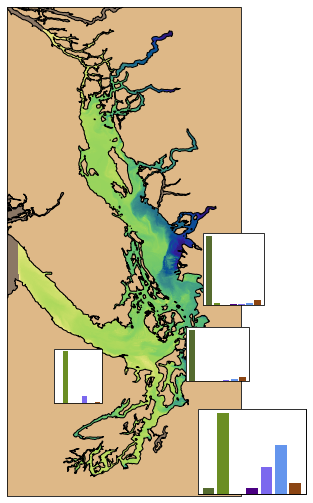

<ipython-input-103-0568b1ab95b9>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [103]:
# the offsets needed for indexing from lower left of graphic boundary
x0 = 0.12
y0 = 0.044

# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

fig,ax = plt.subplots(
    1, 1, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# calculate location of marine terminal within graphic window

#~~~~~~~~~~~~~~~~ NORTH ~~~~~~~~~~~~~~~~~~
xleft = ((north.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((north.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_north = inset_axes(ax, width=1.5, height = 1, 
               bbox_to_anchor=(4*x0+xleft, 1.5*y0+ybottom),
               bbox_transform=ax.transAxes,
               axes_class=cartopy.mpl.geoaxes.GeoAxes, 
               axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()), 
               borderpad=0)
ax_north.bar(oil_types, north_oils * 1e-9, color = oil_colors)

#~~~~~~~~~~~~~~~~ SOUTH ~~~~~~~~~~~~~~~~~~
xleft = ((south.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((south.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_south = inset_axes(ax, width=1.5, height = 2, 
               bbox_to_anchor=(4*x0+xleft, 1.5*y0+ybottom),
               bbox_transform=ax.transAxes,
               axes_class=cartopy.mpl.geoaxes.GeoAxes, 
               axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()), 
               borderpad=0)
ax_south.bar(oil_types, south_oils * 5e-9, color = oil_colors)

#~~~~~~~~~~~~~~~~ ANACORTES ~~~~~~~~~~~~~~~~~~
xleft = ((anacortes.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((anacortes.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_anacortes = inset_axes(ax, width=1, height = .75, 
               bbox_to_anchor=(2.5*x0+xleft, ybottom-y0),
               bbox_transform=ax.transAxes,
               axes_class=cartopy.mpl.geoaxes.GeoAxes, 
               axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()), 
               borderpad=0)
ax_anacortes.bar(oil_types, anacortes_oils * 1e-9, color = oil_colors)

#~~~~~~~~~~~~~~~~ PORT ANGELES ~~~~~~~~~~~~~~~~~~
xleft = ((portangeles.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((portangeles.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_portangeles = inset_axes(ax, width=1, height = .75, 
               bbox_to_anchor=(xleft-x0, ybottom),
               bbox_transform=ax.transAxes,
               axes_class=cartopy.mpl.geoaxes.GeoAxes, 
               axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()), 
               borderpad=0)
ax_portangeles.bar(oil_types, portangeles_oils * 1e-7, color = oil_colors)



#ax_north.bar(oil_types, 1e1* numpy.ones(7), width = 1)
plt.show()
fig.canvas.draw()
fig.tight_layout()
    

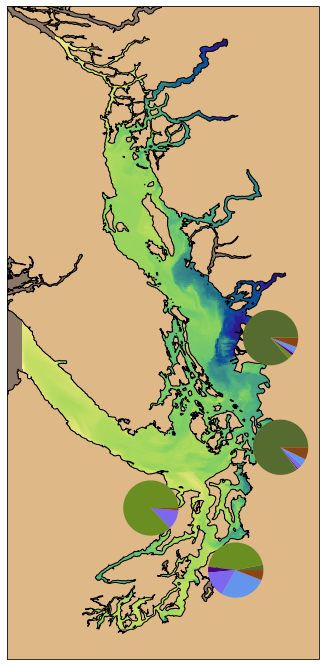

<ipython-input-140-eb210142c034>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [140]:
# the offsets needed for indexing from lower left of graphic boundary
x0 = -0.12
y0 = -0.044

# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

fig,ax = plt.subplots(
    1, 1, figsize=(12, 12), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# calculate location of marine terminal within graphic window

#~~~~~~~~~~~~~~~~ NORTH ~~~~~~~~~~~~~~~~~~
xleft = ((north.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((north.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_north = fig.add_axes([xleft+x0, ybottom+1.7*y0,.08, .2])
ax_north.pie(north_oils, colors = oil_colors)

#~~~~~~~~~~~~~~~~ SOUTH ~~~~~~~~~~~~~~~~~~
xleft = ((south.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((south.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_south = fig.add_axes([xleft+2*x0, ybottom+y0,.08, .2])
ax_south.pie(south_oils, colors = oil_colors)

#~~~~~~~~~~~~~~~~ ANACORTES ~~~~~~~~~~~~~~~~~~
xleft = ((anacortes.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((anacortes.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_anacortes = fig.add_axes([xleft+1.2*x0, ybottom+2.7*y0,.08, .2])
ax_anacortes.pie(anacortes_oils, colors = oil_colors)

#~~~~~~~~~~~~~~~~ PORT ANGELES ~~~~~~~~~~~~~~~~~~
xleft = ((portangeles.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((portangeles.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_portangeles = fig.add_axes([xleft+x0, ybottom+2.3*y0,.08, .2])
ax_portangeles.pie(portangeles_oils, colors = oil_colors)


#ax_north.bar(oil_types, 1e1* numpy.ones(7), width = 1)
plt.show()
fig.canvas.draw()
fig.tight_layout()
    

###### 

In [114]:
ybottom

0.4714678069115235

In [ ]:
fs = 20
scatter_handles = numpy.zeros(len(oil_types))
%matplotlib inline

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

# Use `subplot_kw` arg to pass a dict of kwargs containing the `RotatedPole` CRS
# and the `facecolor` value to the add_subplot() call(s) that subplots() will make
fig,ax = plt.subplots(
    1, 1, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

# Use the `transform` arg to tell cartopy to transform the model field
# between grid coordinates and lon/lat coordinates when it is plotted
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# add WA locations
print(f'oil type, color')
for oil in oil_types:
    index = oil_types.index(oil)
    scatter_handles = ax.scatter(
        wa_locs['DockLongNumber'],
        wa_locs['DockLatNumber'],
        s = 600*wa_locs[f'{oil}_scale'],
        transform=plain_crs, 
        color=oil_colors[index],
        edgecolors='white',
        linewidth=1,
        label=oil
    )
    print(f'{oil}, {oil_colors[index]}')
#plt.legend(handles = scatter_handles)
#plt.show()

# add BC locations
ax.scatter(
    bc_locs['Longitude'],
    bc_locs['Latitude'],
    transform=plain_crs, 
    color='black',
    marker = 'x'
    
)

# Colour bar
cbar = plt.colorbar(quad_mesh, ax=ax)
cbar.set_label(f"{salinity.attrs['long_name']} [{salinity.attrs['units']}]")
# Axes title; ax.gridlines() below labels axes tick in a way that makes
# additional axes labels unnecessary IMHO
ax.set_title(f"Imports of all oil types, scaled by magnitude of individual type", fontsize=fs)

# Don't call set_aspect() because plotting on lon/lat grid implicitly makes the aspect ratio correct

# Show grid lines
# Note that ax.grid() has no effect; ax.gridlines() is from cartopy, not matplotlib
ax.gridlines(draw_labels=True, auto_inline=False)

# cartopy doesn't seem to play nice with tight_layout() unless we call canvas.draw() first
fig.canvas.draw()
fig.tight_layout()

fig.savefig('oil_by_type_location.png')

In [ ]:
fs = 20
%matplotlib inline

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

# Use `subplot_kw` arg to pass a dict of kwargs containing the `RotatedPole` CRS
# and the `facecolor` value to the add_subplot() call(s) that subplots() will make
fig,ax = plt.subplots(
    1, 1, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

# Use the `transform` arg to tell cartopy to transform the model field
# between grid coordinates and lon/lat coordinates when it is plotted
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# add WA locations
ax.scatter(
    wa_locs['DockLongNumber'],
    wa_locs['DockLatNumber'],
    s = 600*wa_locs['all_scale'],
    transform=plain_crs, 
    color='maroon',
    edgecolors='white',
    linewidth=1
)

#add BC locations
ax.scatter(
    bc_locs['Longitude'],
    bc_locs['Latitude'],
    transform=plain_crs, 
    color='black',
    marker='x'
)

# Colour bar
cbar = plt.colorbar(quad_mesh, ax=ax)
cbar.set_label(f"{salinity.attrs['long_name']} [{salinity.attrs['units']}]")
# Axes title; ax.gridlines() below labels axes tick in a way that makes
# additional axes labels unnecessary IMHO
ax.set_title('Imports of all oil types', fontsize=fs)

# Don't call set_aspect() because plotting on lon/lat grid implicitly makes the aspect ratio correct

# Show grid lines
# Note that ax.grid() has no effect; ax.gridlines() is from cartopy, not matplotlib
ax.gridlines(draw_labels=True, auto_inline=False)

# cartopy doesn't seem to play nice with tight_layout() unless we call canvas.draw() first
fig.canvas.draw()
fig.tight_layout()
fig.savefig('oil_all_location.png')

### Now add spill locations

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
wa_locs.DockLongNumber[0]+0.25

In [ ]:
fs = 20
scatter_handles = numpy.zeros(len(oil_types))
%matplotlib inline

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

# Use `subplot_kw` arg to pass a dict of kwargs containing the `RotatedPole` CRS
# and the `facecolor` value to the add_subplot() call(s) that subplots() will make
fig,ax = plt.subplots(
    1, 1, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

# Use the `transform` arg to tell cartopy to transform the model field
# between grid coordinates and lon/lat coordinates when it is plotted
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# add WA locations
print(f'oil type, color')
for oil in oil_types:
    index = oil_types.index(oil)
    scatter_handles = ax.scatter(
        wa_locs['DockLongNumber'],
        wa_locs['DockLatNumber'],
        s = 600*wa_locs[f'{oil}_scale'],
        transform=plain_crs, 
        color=oil_colors[index],
        edgecolors='white',
        linewidth=1,
        label=oil
    )
    print(f'{oil}, {oil_colors[index]}')

# inaxes = inset_axes(ax,
#                     width="30%", # width = 30% of parent_bbox
#                     height=1., # height : 1 inch
#                     loc=3)    

# ax.inset_axes([wa_locs.DockLongNumber[0],wa_locs.DockLatNumber[0], 0.5, 0.5], 
#              transform=plain_crs)   

ax_sub= inset_axes(ax, width=0.5, height=0.5, 
                   bbox_to_anchor=(0.5, 0.5),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()), 
                   borderpad=0)
#    wedges,texts= ax_sub.pie(data)

# #axins = zoomed_inset_axes(ax, 6, loc=1)  # zoom = 6
# # define location of inset graphic
# x1, x2, y1, y2 = [wa_locs.DockLongNumber[0]-0.25,  
#                   wa_locs.DockLongNumber[0]+0.25,  
#                   wa_locs.DockLatNumber[0]-0.25, 
#                   wa_locs.DockLatNumber[0]+0.25
#                  ]
# inaxes.set_xlim(x1, x2)
# inaxes.set_ylim(y1, y2)

#plt.legend(handles = scatter_handles)
#plt.show()

# add BC locations
ax.scatter(
    bc_locs['Longitude'],
    bc_locs['Latitude'],
    transform=plain_crs, 
    color='black',
    marker = 'x'
    
)

# Colour bar
cbar = plt.colorbar(quad_mesh, ax=ax)
cbar.set_label(f"{salinity.attrs['long_name']} [{salinity.attrs['units']}]")
# Axes title; ax.gridlines() below labels axes tick in a way that makes
# additional axes labels unnecessary IMHO
ax.set_title(f"Imports of all oil types, scaled by magnitude of individual type", fontsize=fs)

# Don't call set_aspect() because plotting on lon/lat grid implicitly makes the aspect ratio correct

# Show grid lines.  ax.gridlines() is from cartopy, not matplotlib
ax.gridlines(draw_labels=True, auto_inline=False)

# cartopy doesn't seem to play nice with tight_layout() unless we call canvas.draw() first
fig.canvas.draw()
#fig.tight_layout()

fig.savefig('oil_by_type_location.png')